# Visual Language Models (VLMs) Lab Exercise
## ITAI 1378 - Module 08

---

### Lab Overview

Welcome to the VLM Lab! In this hands-on exercise, you'll explore the fascinating world of Visual Language Models - AI systems that can understand and reason about both images and text.

**Estimated Time:** 2-2.5 hours

### Learning Outcomes

By the end of this lab, you will be able to:

1. **Understand VLMs and Their Architectures**: Explain how VLMs work and differentiate between major architectural approaches (CLIP, BLIP, LLaVA)
2. **Understand Applications of VLMs**: Identify and implement practical applications like image search, captioning, and visual question answering
3. **Evaluate and Apply**: Analyze trade-offs between different VLM approaches and make informed decisions for real-world problems

### Two Paths Available

This lab provides **two implementation paths** based on your available compute resources:

- **🚀 Path A (Limited Compute)**: Uses CLIP and smaller models - runs on CPU or basic GPU
- **⚡ Path B (More Resources)**: Uses BLIP-2 and larger models - requires GPU with 8GB+ VRAM

**You only need to complete ONE path**, but you're welcome to explore both!

---

### 🤖 Using AI Assistants Effectively

**You are encouraged to use AI assistants (ChatGPT, Claude, etc.) for coding help!** However, use them wisely:

✅ **Good uses:**
- Understanding error messages
- Learning Python syntax and concepts
- Debugging code that isn't working
- Explaining what a code block does

❌ **Avoid:**
- Copy-pasting reflection questions into AI without thinking first
- Having AI write your conceptual answers
- Using AI to skip the learning process

**Remember**: The reflection questions are designed to make you think critically. Write your own thoughts first, then optionally discuss with AI to refine your understanding.

---

## Section 0: Environment Setup

Let's start by setting up our environment and installing the necessary libraries.

### 📚 For Python Beginners

- **Libraries/Packages**: Collections of pre-written code that add functionality
- **pip**: Python's package installer (like an app store for code)
- **!** in Jupyter: Runs a command in the terminal, not in Python
- **import**: Brings a library's functionality into your code

**💡 Tip**: If installation fails, try restarting the kernel (Kernel → Restart) and running again.

In [ ]:
# Install required packages
# This might take 3-5 minutes - be patient!

!pip install -q torch torchvision transformers pillow matplotlib datasets
!pip install -q ftfy regex tqdm
!pip install -q sentencepiece  # For some models

print("✓ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
✓ Installation complete!


In [ ]:
# Import libraries
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import CLIPProcessor, CLIPModel
from transformers import BlipProcessor, BlipForConditionalGeneration, BlipForQuestionAnswering
from datasets import load_dataset
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Running on CPU - consider using Path A (Limited Compute)")

Using device: cuda
GPU: Tesla T4
Available GPU memory: 15.83 GB


### ✅ Knowledge Check 1: Environment

**Question**: What is the purpose of checking for GPU availability in the code above? Why might some VLM operations be slow on CPU?

**Your Answer**:
Checking for GPU availability lets the code decide whether to run on a graphics processor (GPU) or the regular CPU. GPUs are designed to handle thousands of operations in parallel, which makes them much faster for deep learning tasks like processing images and running large models. If a GPU isn’t available, the code falls back to the CPU, but since CPUs process tasks sequentially, operations like embedding calculations and matrix multiplications can run much slower.

---

## Section 1: Understanding VLM Fundamentals

Before we dive into code, let's explore the core concepts that make VLMs work.

### 🎯 Recall: The Three Building Blocks

Every VLM consists of three core components:

1. **Vision Encoder** 🖼️ - Converts images into numerical representations (embeddings)
2. **Language Model** 🧠 - Understands and generates text
3. **The Bridge** 🌉 - Connects vision and language (via cross-attention or projection)

### The Magic of Shared Embedding Space

The key insight: **Both images and text are converted into vectors in the same high-dimensional space**. This allows us to:

- Measure how similar an image is to a text description
- Find images that match a text query
- Generate text descriptions of images

Let's visualize this concept!

In [ ]:
# Helper function to load images from URLs
def load_image_from_url(url):
    """Load an image from a URL."""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Helper function to display images
def show_images(images, titles=None, cols=3):
    """Display multiple images in a grid."""
    n_images = len(images)
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for idx, img in enumerate(images):
        row = idx // cols
        col = idx % cols
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if titles and idx < len(titles):
            axes[row, col].set_title(titles[idx], fontsize=12, wrap=True)

    # Hide empty subplots
    for idx in range(n_images, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

print("✓ Helper functions defined!")

✓ Helper functions defined!


### 🤔 Reflection Question 1: The Alignment Problem

In the lecture, we discussed the "alignment problem" - the challenge of creating a shared representation space where visual and textual concepts are aligned.

**Question**: Why is it challenging to align vision and language? Think about:
- How images and text are fundamentally different
- What makes the word "cat" similar to a picture of a cat in a meaningful way
- What information might be lost or gained when converting each modality to embeddings

**Your Answer**:
_(Take 5 minutes to think and write your answer here before continuing)_
- Aligning vision and language is tough because images and text are totally different one’s pixels, the other’s symbols. The model has to learn that a word like “cat” matches all kinds of cat pictures, even with different poses or lighting. When converting both into embeddings, some detail gets lost like background or phrasing but semantic meaning, the idea of “catness” is kept. The model gains shared meaning but can also pick up biases from training data.
---

## Section 2: Exploring VLM Architectures

Now let's explore the different architectural approaches discussed in the lecture.

### Architecture Comparison (From Lecture)

| Architecture | Approach | Key Feature | Best For |
|-------------|----------|-------------|----------|
| CLIP | Contrastive | Zero-shot classification | Simple classification, search |
| BLIP | Projector + Gen | Bootstrapping data | VQA, Captioning |
| LLaVA | Projector | Instruction tuning | Multimodal chat, reasoning |
| Flamingo | Adapter | Few-shot learning | Tasks with limited data |
| GPT-4V | Integrated | State-of-the-art | Complex reasoning, analysis |

### Choose Your Path!

- **Path A (Limited Compute)**: We'll use **CLIP** - excellent for zero-shot tasks, runs on CPU
- **Path B (More Resources)**: We'll use **BLIP-2** - better for generation tasks, needs GPU

---

## 🚀 PATH A: Limited Compute (CLIP)

### Introduction to CLIP

**CLIP (Contrastive Language-Image Pre-training)** was developed by OpenAI and trained on 400 million image-text pairs from the internet.

**Key Innovation**: Contrastive learning
- Given a batch of images and text descriptions
- Learn to match correct pairs (positive examples)
- Push apart incorrect pairs (negative examples)

**Result**: A shared embedding space where similar images and text are close together!

### Applications of CLIP
1. Zero-shot image classification
2. Image-text similarity/search
3. Foundation for other models (like Stable Diffusion)

Let's load CLIP and explore its capabilities.

In [ ]:
# PATH A: Load CLIP model (runs on CPU)
print("Loading CLIP model... (this may take 1-2 minutes)")

model_name = "openai/clip-vit-base-patch32"  # Smaller, faster version
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)

# Move to device (GPU if available, CPU otherwise)
clip_model = clip_model.to(device)

print("✓ CLIP model loaded successfully!")
print(f"Model size: ~600MB")
print(f"Embedding dimension: {clip_model.config.projection_dim}")

Loading CLIP model... (this may take 1-2 minutes)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✓ CLIP model loaded successfully!
Model size: ~600MB
Embedding dimension: 512


### 📚 Understanding the Code

- **`from_pretrained()`**: Loads a pre-trained model (saved weights) instead of training from scratch
- **Processor**: Handles pre-processing (resizing images, tokenizing text) to match model's expected input format
- **`.to(device)`**: Moves model to GPU (if available) or keeps on CPU
- **Embedding dimension**: The size of the vector representation (higher = more expressive, but slower)

---

### Experiment 1: Zero-Shot Image Classification

Let's test CLIP's zero-shot classification capability. We'll classify images into categories that CLIP has never explicitly been trained to recognize!

Loading sample images from COCO dataset...


README.md:   0%|          | 0.00/246 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

data/restval-00000-of-00001.parquet:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/82783 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating restval split:   0%|          | 0/30504 [00:00<?, ? examples/s]

Keys available in the dataset:
dict_keys(['filepath', 'sentids', 'filename', 'imgid', 'split', 'sentences', 'cocoid', 'url'])
Image loaded! Size: (428, 640)


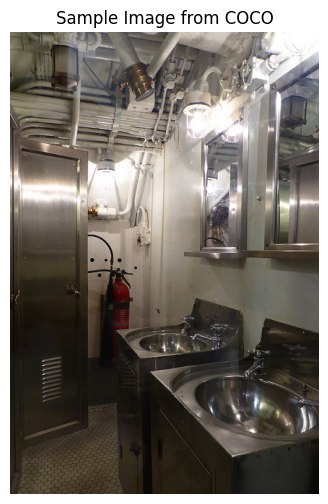

Caption: There are two sinks next to two mirrors.


In [ ]:
# Load a sample image from COCO dataset
print("Loading sample images from COCO dataset...")

# Load COCO validation dataset (small subset)
coco_dataset = load_dataset("yerevann/coco-karpathy", split="validation[:20]")  # Just 20 images for speed

# Print the keys available in the dataset object to diagnose the issue
print("Keys available in the dataset:")
print(coco_dataset.features.keys())

# Get a random image index
import random
random_index = random.randint(0, len(coco_dataset) - 1)

# Get the image URL instead of filepath
image_url = coco_dataset[random_index]['url']

print(f"Downloading image from: {image_url}")

# Download and open the image from URL
response = requests.get(image_url)
sample_image = Image.open(BytesIO(response.content))

print(f"Image loaded! Size: {sample_image.size}")

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(sample_image)
plt.axis('off')
plt.title("Sample Image from COCO")
plt.show()

# Fix: sentences might be a list of dicts or a different structure
sentences = coco_dataset[random_index]['sentences']
if isinstance(sentences, list) and len(sentences) > 0:
    if isinstance(sentences[0], dict):
        print(f"Caption: {sentences[0]['raw']}")
    else:
        print(f"Caption: {sentences[0]}")
else:
    print(f"Caption: {sentences}")


=== Classification Results ===
a photo of a vehicle: 0.4524 (45.24%)
a photo of food: 0.4010 (40.10%)
a photo of a person: 0.0759 (7.59%)
a photo of a cat: 0.0393 (3.93%)
a photo of a dog: 0.0314 (3.14%)


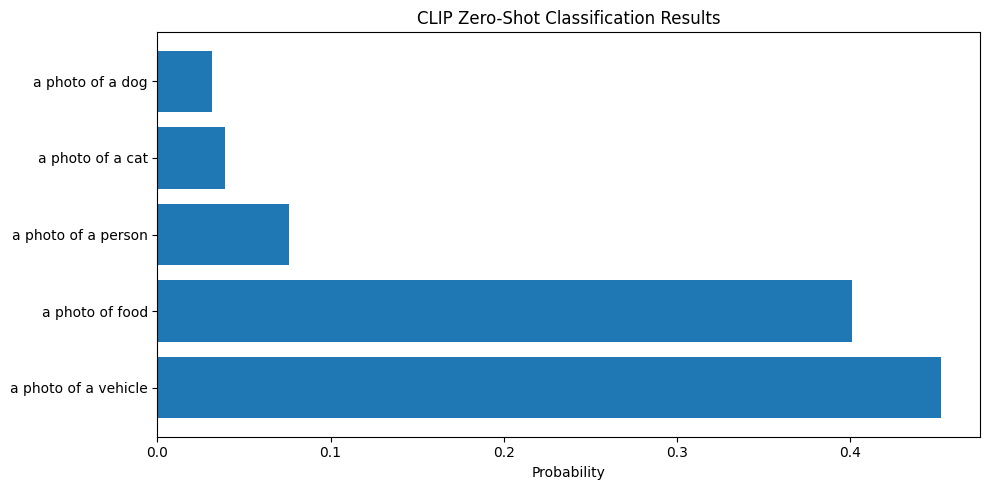

In [ ]:
# Zero-shot classification with CLIP
def classify_image_clip(image, text_labels):
    """
    Classify an image using CLIP with provided text labels.

    Args:
        image: PIL Image
        text_labels: List of text descriptions (categories)

    Returns:
        Dictionary with probabilities for each label
    """
    # Process inputs
    inputs = clip_processor(
        text=text_labels,
        images=image,
        return_tensors="pt",
        padding=True
    ).to(device)

    # Get model predictions
    with torch.no_grad():  # Don't compute gradients (faster, uses less memory)
        outputs = clip_model(**inputs)

    # Calculate similarity scores (logits)
    logits_per_image = outputs.logits_per_image

    # Convert to probabilities
    probs = logits_per_image.softmax(dim=1).cpu().numpy()[0]

    # Create results dictionary
    results = {label: prob for label, prob in zip(text_labels, probs)}
    return results

# Test with different categories
categories = [
    "a photo of a dog",
    "a photo of a cat",
    "a photo of a person",
    "a photo of food",
    "a photo of a vehicle"
]

results = classify_image_clip(sample_image, categories)

# Display results
print("\n=== Classification Results ===")
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
for label, prob in sorted_results:
    print(f"{label}: {prob:.4f} ({prob*100:.2f}%)")

# Visualize
plt.figure(figsize=(10, 5))
labels = [item[0] for item in sorted_results]
probs = [item[1] for item in sorted_results]
plt.barh(labels, probs)
plt.xlabel('Probability')
plt.title('CLIP Zero-Shot Classification Results')
plt.tight_layout()
plt.show()

### 💡 What Just Happened?

1. We gave CLIP an image and several text descriptions
2. CLIP computed **embeddings** (vector representations) for both the image and each text description
3. It measured the **similarity** between the image embedding and each text embedding
4. Higher similarity = higher probability that the text describes the image

**The Magic**: CLIP was never explicitly trained on these specific categories! It learned general image-text relationships from 400M examples.

---

### ✅ Knowledge Check 2: Zero-Shot Learning

**Question 1**: What does "zero-shot" mean in the context of CLIP? Why is this capability valuable?

**Your Answer**:
“Zero-shot” basically means CLIP can figure out what’s in an image even if it’s never seen that exact category before. It doesn’t need extra training, it just uses what it already knows about how pictures and words relate. That’s super useful because it can handle new stuff right away without retraining the model.

**Question 2**: Look at the classification results above. Try modifying the `categories` list to test different classifications. What happens if you make the categories more specific (e.g., "a golden retriever" vs "a photo of a dog")?

**Your Observations**:
When I make the labels more specific, like “a golden retriever” instead of “a dog,” the results change a bit. If the image really looks like that exact thing, the score goes up. If not, it drops. It shows CLIP pays attention to small wording changes and tries to match the description more closely.

---

### Experiment 2: Image-Text Retrieval

Now let's use CLIP for **image search** - finding images that match a text query. This is similar to Google Images or Pinterest visual search!

Loading 12 images from COCO...
✓ Loaded 12 images


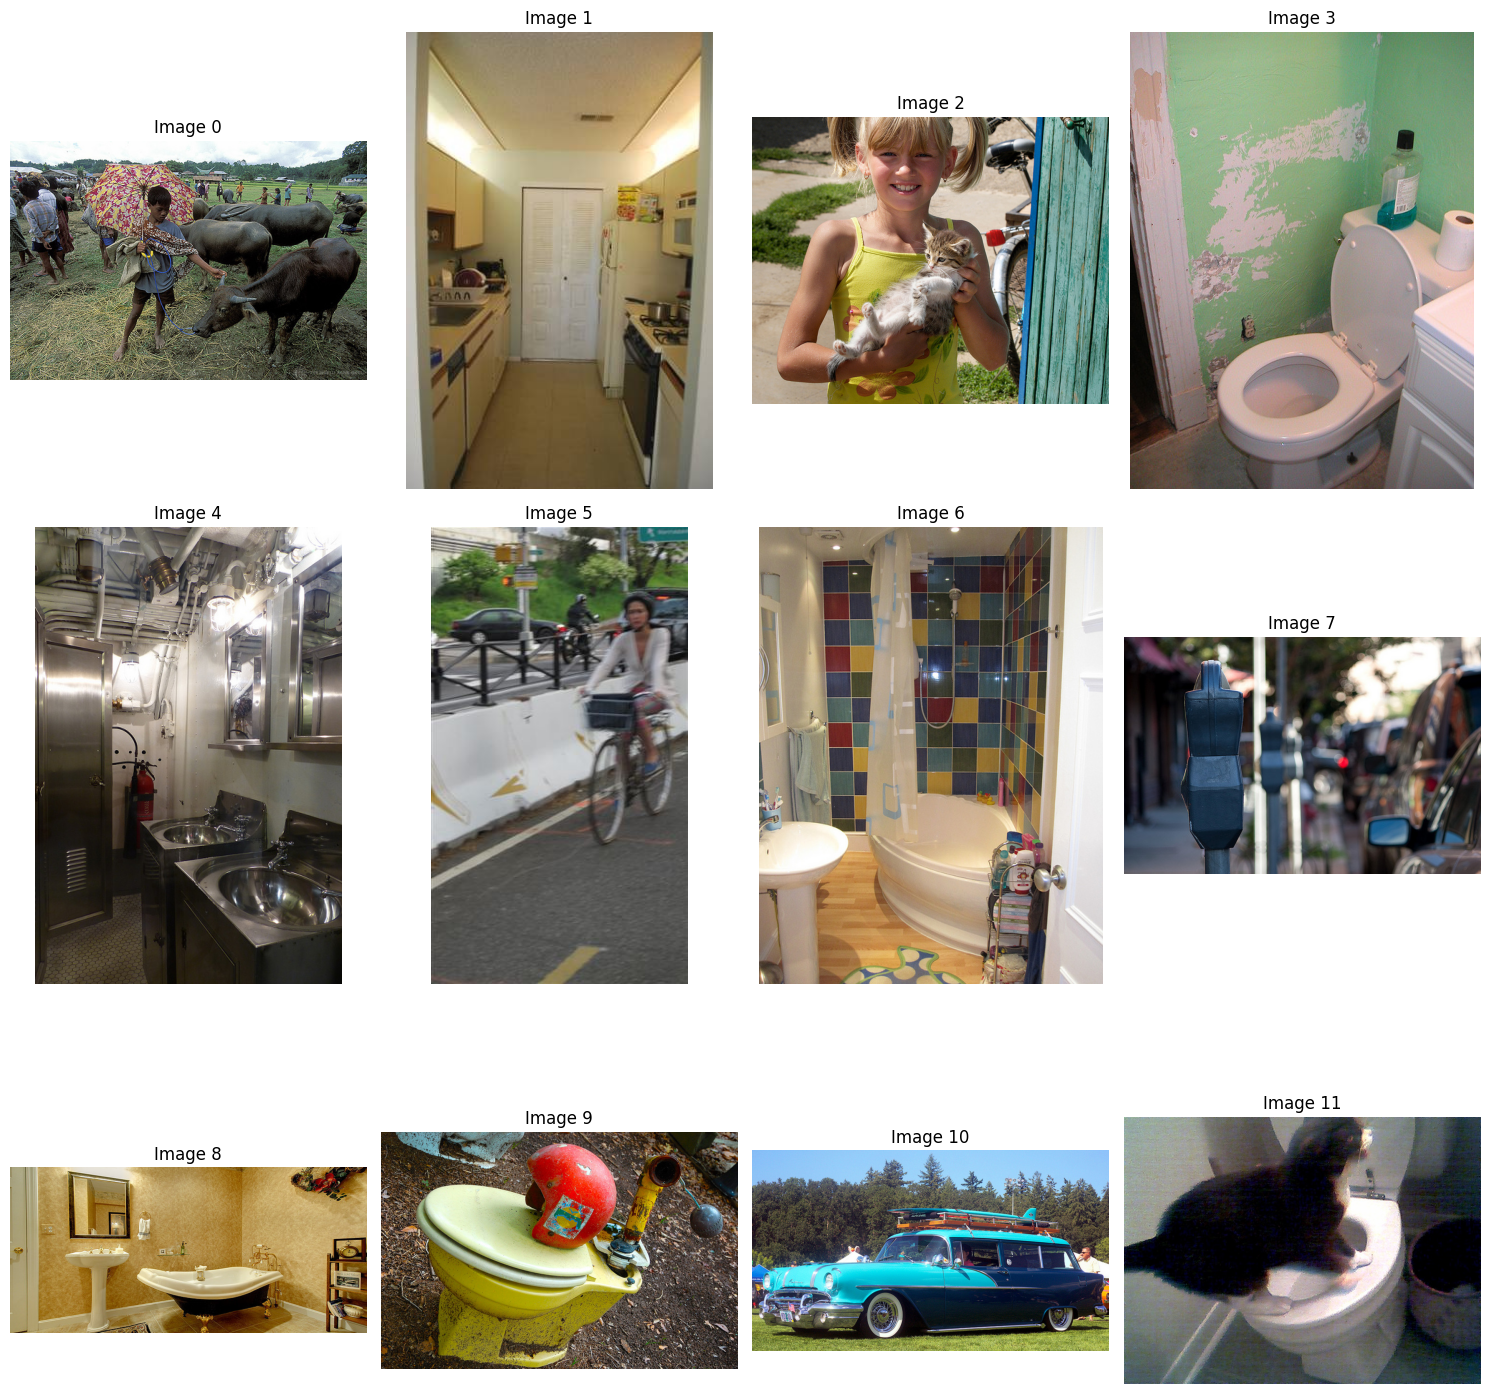

In [ ]:
# Load multiple images from COCO
num_images = 12
print(f"Loading {num_images} images from COCO...")

images = []
captions = []

for i in range(min(num_images, len(coco_dataset))):
    # Download image from URL
    image_url = coco_dataset[i]['url']
    try:
        response = requests.get(image_url, timeout=10)
        img = Image.open(BytesIO(response.content))
        images.append(img)

        # Get caption
        sentences = coco_dataset[i]['sentences']
        if isinstance(sentences, list) and len(sentences) > 0:
            if isinstance(sentences[0], dict):
                captions.append(sentences[0]['raw'])
            else:
                captions.append(sentences[0])
        else:
            captions.append("No caption available")
    except Exception as e:
        print(f"Failed to load image {i}: {e}")
        continue

print(f"✓ Loaded {len(images)} images")

# Display the images
show_images(images, titles=[f"Image {i}" for i in range(len(images))], cols=4)


=== Searching for: 'people playing sports' ===


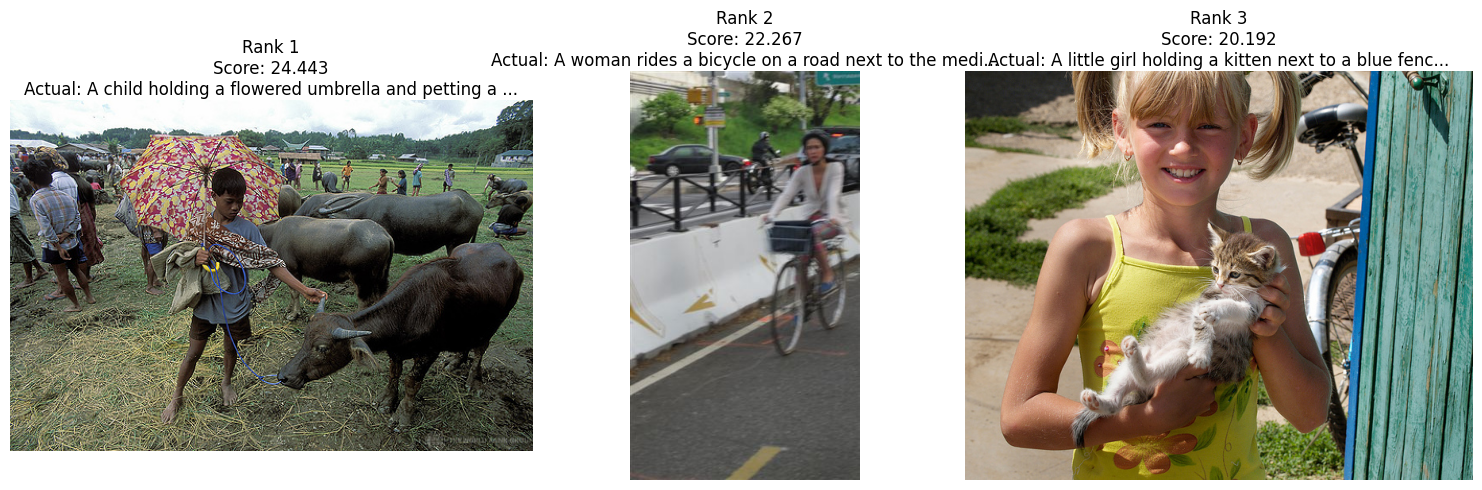


=== Searching for: 'animals in nature' ===


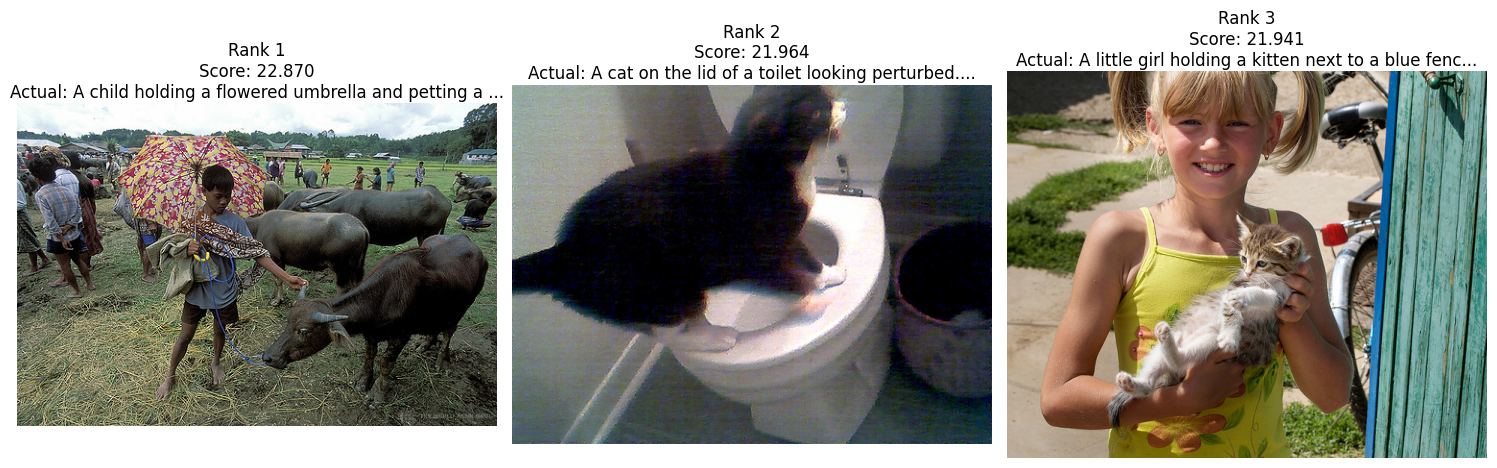


=== Searching for: 'food on a table' ===


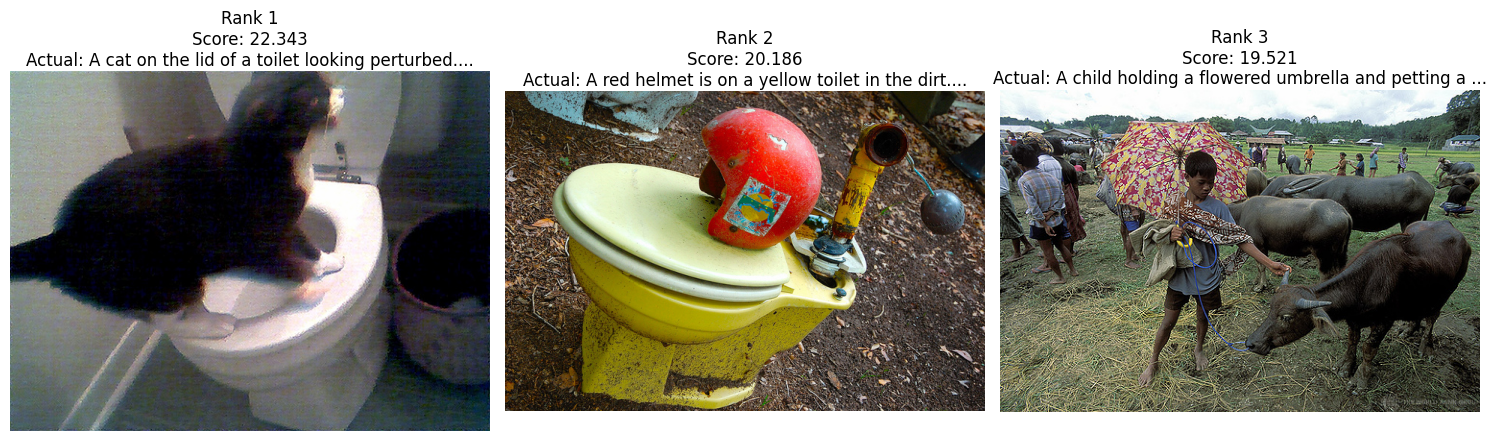

In [ ]:
# Image search function
def search_images_clip(images, text_query, top_k=3):
    """
    Search for images that match a text query using CLIP.

    Args:
        images: List of PIL Images
        text_query: Text description to search for
        top_k: Number of top results to return

    Returns:
        List of (index, score) tuples for top matches
    """
    # Process all images and the text query
    inputs = clip_processor(
        text=[text_query],
        images=images,
        return_tensors="pt",
        padding=True
    ).to(device)

    # Get embeddings
    with torch.no_grad():
        outputs = clip_model(**inputs)

    # Calculate similarity scores
    logits_per_text = outputs.logits_per_text  # Shape: [1, num_images]
    scores = logits_per_text[0].cpu().numpy()

    # Get top-k indices
    top_indices = np.argsort(scores)[::-1][:top_k]
    top_scores = scores[top_indices]

    return list(zip(top_indices, top_scores))

# Try different search queries
queries = [
    "people playing sports",
    "animals in nature",
    "food on a table"
]

for query in queries:
    print(f"\n=== Searching for: '{query}' ===")
    results = search_images_clip(images, query, top_k=3)

    # Display results
    top_images = [images[idx] for idx, _ in results]
    top_titles = [f"Rank {i+1}\nScore: {score:.3f}\nActual: {captions[idx][:50]}..."
                  for i, (idx, score) in enumerate(results)]

    show_images(top_images, titles=top_titles, cols=3)

### 🤔 Reflection Question 2: Search Quality

Look at the search results for different queries.

**Question**:
1. How well did CLIP perform on these searches? Were the top results relevant?
- For simple and clear queries like “people playing sports” or “food on a table,” the top matches looked accurate and made sense. The images it picked usually fit the description, though sometimes one or two results were a bit off when the scene was too busy or the subject wasn’t very clear.
2. Try creating your own search queries in the code above. What types of queries work well vs. poorly?
- The model handled concrete things best—like objects, people, or scenes that are easy to see. It struggled more with abstract or complex phrases. For example, “a red car” or “a cat on a bed” worked really well, but something like “happiness” or “a man standing behind a woman” didn’t match as accurately. Basically, the simpler and more visual the phrase, the better CLIP performs.
3. Why might some queries be harder for CLIP than others? Think about:
   - Abstract concepts vs. concrete objects
   - Relationships between objects
   - Fine-grained details
- Some searches are just trickier because CLIP focuses on visible things, not abstract ideas or small details. It’s easier for the model to match “a pizza” than “a cozy dinner” because “cozy” depends on feeling, not appearance. It also struggles with fine-grained differences (like dog breeds) or spatial relationships (“left of,” “under”), since those need more detailed understanding than CLIP’s single embedding can capture.

### Experiment 3: Understanding Embeddings

Let's peek "under the hood" and visualize what the embedding space looks like.

In [ ]:
# Extract embeddings for images and text
def get_clip_embeddings(images, texts):
    """
    Get CLIP embeddings for images and texts.

    Returns:
        image_embeddings: numpy array of shape [num_images, embedding_dim]
        text_embeddings: numpy array of shape [num_texts, embedding_dim]
    """
    # Process images
    image_inputs = clip_processor(images=images, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = clip_model.get_image_features(**image_inputs)

    # Process text
    text_inputs = clip_processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)

    # Normalize embeddings (CLIP uses cosine similarity)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    return image_features.cpu().numpy(), text_features.cpu().numpy()

# Get embeddings
sample_texts = [
    "a photo of a cat",
    "a photo of a dog",
    "people playing sports",
    "delicious food"
]

image_embeds, text_embeds = get_clip_embeddings(images[:8], sample_texts)

print(f"Image embeddings shape: {image_embeds.shape}")
print(f"Text embeddings shape: {text_embeds.shape}")
print(f"\nEach item is represented by a {image_embeds.shape[1]}-dimensional vector!")

Image embeddings shape: (8, 512)
Text embeddings shape: (4, 512)

Each item is represented by a 512-dimensional vector!


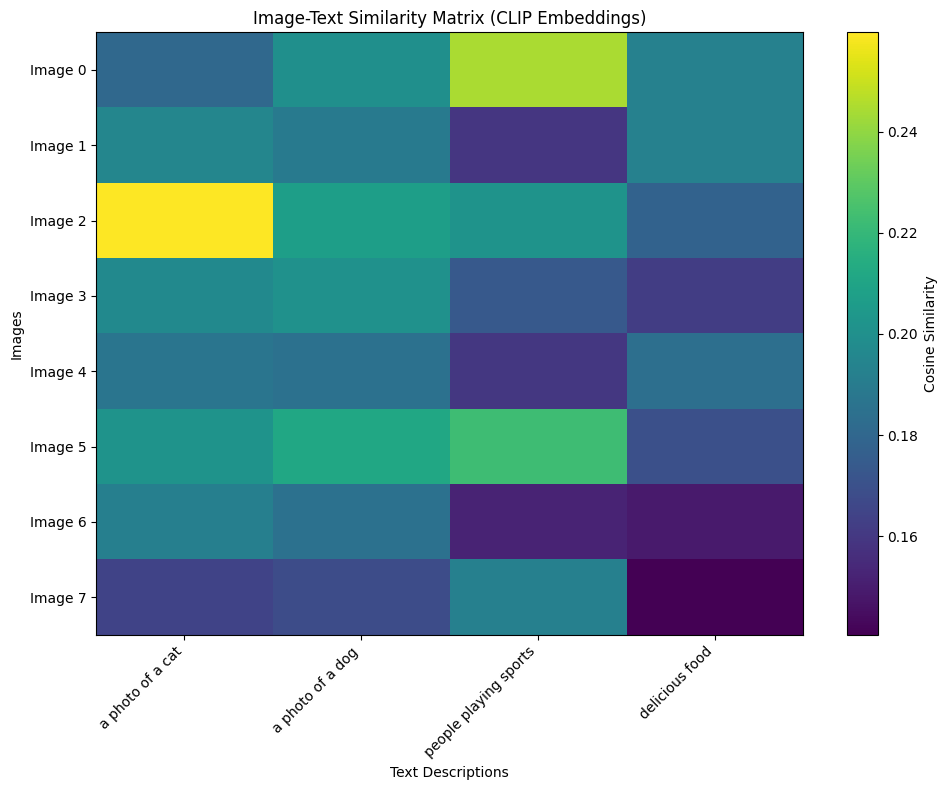


💡 Interpretation:
- Brighter colors = higher similarity between image and text
- Each cell shows how well an image matches a text description
- This is the core of how CLIP performs zero-shot classification!


In [ ]:
# Visualize similarity matrix
similarity_matrix = image_embeds @ text_embeds.T  # Matrix multiplication

plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Text Descriptions')
plt.ylabel('Images')
plt.xticks(range(len(sample_texts)), sample_texts, rotation=45, ha='right')
plt.yticks(range(len(images[:8])), [f"Image {i}" for i in range(8)])
plt.title('Image-Text Similarity Matrix (CLIP Embeddings)')
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("- Brighter colors = higher similarity between image and text")
print("- Each cell shows how well an image matches a text description")
print("- This is the core of how CLIP performs zero-shot classification!")

### ✅ Knowledge Check 3: Embeddings

**Question 1**: What is an embedding, and why do we need them? (Hint: Think about how computers represent things)

**Your Answer**:
An embedding is like a numerical fingerprint for data, it turns words or images into long lists of numbers that capture their meaning. We need embeddings because computers don’t understand pictures or text directly; they need everything represented as numbers. With embeddings, similar things (like “dog” and a photo of a dog) end up close together in the model’s space, making it easier for AI to compare and understand relationships.

**Question 2**: Look at the similarity matrix above. What does a high similarity score (bright color) tell you about the relationship between an image and a text description?

**Your Answer**:
A high similarity score (the bright color in the matrix) means that the image and the text have very similar embeddings. Basically, the model thinks they represent the same idea. So if an image of a cat glows bright next to “a photo of a cat,” it means CLIP strongly believes that text describes the picture.

**Question 3**: CLIP uses **cosine similarity** (measuring the angle between vectors) rather than Euclidean distance. Why might angle be a better measure than distance for semantic similarity?

**Your Answer**:
Cosine similarity focuses on the direction of the vectors instead of how long they are. That’s helpful because the direction shows meaning, while the length might just reflect things like brightness or scale. Measuring angle helps CLIP tell when two things “point” to the same concept, even if their overall magnitude is different.


---

### 🎯 PATH A CHECKPOINT

**Congratulations!** You've completed the core CLIP experiments.

**What you've learned so far:**
- ✅ How CLIP creates a shared embedding space for images and text
- ✅ Zero-shot classification without task-specific training
- ✅ Image search using text queries
- ✅ How embeddings and similarity scores work

**Continue to Section 3** for fine-tuning and advanced topics!

---

## ⚡ PATH B: More Resources (BLIP/BLIP-2)

### Introduction to BLIP

**BLIP (Bootstrapping Language-Image Pre-training)** goes beyond CLIP by adding **generation capabilities**.

**Key Features:**
- **Understands** images (like CLIP)
- **Generates** captions and answers questions (unlike CLIP)
- **Bootstraps** training data by generating and filtering its own captions

**Architecture:**
- Vision Encoder (similar to CLIP)
- Q-Former: A "bridge" that connects vision to language
- Language Model: Generates text

**Applications:**
1. Image captioning
2. Visual Question Answering (VQA)
3. Image-text retrieval

⚠️ **Note**: BLIP requires more computational resources than CLIP. Make sure you have a GPU with at least 8GB VRAM.

In [ ]:
# PATH B: Load BLIP model for image captioning
print("Loading BLIP model... (this may take 2-3 minutes)")

# Check if we have enough GPU memory
if device == "cpu":
    print("⚠️ Warning: Running BLIP on CPU will be VERY slow.")
    print("Consider using Path A (CLIP) instead, or use a GPU environment.")
    # Optionally, uncomment the line below to prevent loading on CPU
    # raise Exception("BLIP requires GPU. Please use Path A or switch to a GPU environment.")

# Load model for captioning
blip_caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Load model for VQA
blip_vqa_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
blip_vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

print("✓ BLIP models loaded successfully!")
print(f"Caption model size: ~990MB")
print(f"VQA model size: ~990MB")

### 📚 Understanding the Code

- **Two separate models**: One for captioning, one for VQA (different tasks, different fine-tuning)
- **BlipForConditionalGeneration**: A model that can generate text (captions) from images
- **BlipForQuestionAnswering**: Specialized for answering questions about images
- These are **task-specific** models, unlike CLIP which is more general-purpose

---

In [ ]:
# Load sample images (same as Path A)
print("Loading sample images from COCO dataset...")
coco_dataset = load_dataset("yerevann/coco-karpathy", split="validation[:20]")

images_pathb = []
captions_pathb = []

for i in range(12):
    # Download image from URL
    image_url = coco_dataset[i]['url']
    try:
        response = requests.get(image_url, timeout=10)
        img = Image.open(BytesIO(response.content))
        images_pathb.append(img)

        # Get caption
        sentences = coco_dataset[i]['sentences']
        if isinstance(sentences, list) and len(sentences) > 0:
            if isinstance(sentences[0], dict):
                captions_pathb.append(sentences[0]['raw'])
            else:
                captions_pathb.append(sentences[0])
        else:
            captions_pathb.append("No caption available")
    except Exception as e:
        print(f"Failed to load image {i}: {e}")
        continue

print(f"✓ Loaded {len(images_pathb)} images")
show_images(images_pathb[:6], titles=[f"Image {i}" for i in range(6)], cols=3)

### Experiment 1: Image Captioning

Let's generate natural language descriptions of images!

In [ ]:
# Generate captions
def generate_caption_blip(image):
    """
    Generate a caption for an image using BLIP.

    Args:
        image: PIL Image

    Returns:
        Generated caption (string)
    """
    # Process image
    inputs = blip_caption_processor(images=image, return_tensors="pt").to(device)

    # Generate caption
    with torch.no_grad():
        output = blip_caption_model.generate(**inputs, max_length=50)

    # Decode the output
    caption = blip_caption_processor.decode(output[0], skip_special_tokens=True)
    return caption

# Test on several images
print("\n=== Generating Captions ===")
for i in range(6):
    image = images_pathb[i]
    generated_caption = generate_caption_blip(image)
    actual_caption = captions_pathb[i]

    print(f"\nImage {i+1}:")
    print(f"Generated: {generated_caption}")
    print(f"Actual:    {actual_caption}")

# Visualize
sample_idx = 0
plt.figure(figsize=(8, 6))
plt.imshow(images_pathb[sample_idx])
plt.axis('off')
generated = generate_caption_blip(images_pathb[sample_idx])
plt.title(f"Generated Caption:\n{generated}", fontsize=12, wrap=True)
plt.show()

### 💡 What Just Happened?

1. BLIP's vision encoder converted the image into embeddings
2. The Q-Former "queries" these embeddings to extract relevant information
3. The language model generates text, token by token, based on the visual information
4. This is **generative** - BLIP is creating new text, not just classifying!

**Key Difference from CLIP**: CLIP can only match/score existing text. BLIP can generate new descriptions.

---

### ✅ Knowledge Check 2 (Path B): Generation vs. Classification

**Question 1**: What is the fundamental difference between CLIP's zero-shot classification and BLIP's caption generation? Think about their outputs.

**Your Answer**:
_(Type your answer here)_

**Question 2**: Look at the generated captions vs. actual captions. How well did BLIP do? What kinds of details did it capture? What did it miss?

**Your Analysis**:
_(Write your observations)_

---

### Experiment 2: Visual Question Answering (VQA)

Now let's ask questions about images! This is more interactive than captioning.

In [ ]:
# VQA function
def answer_question_blip(image, question):
    """
    Answer a question about an image using BLIP.

    Args:
        image: PIL Image
        question: Question string

    Returns:
        Answer string
    """
    # Process image and question
    inputs = blip_vqa_processor(images=image, text=question, return_tensors="pt").to(device)

    # Generate answer
    with torch.no_grad():
        output = blip_vqa_model.generate(**inputs, max_length=20)

    # Decode the answer
    answer = blip_vqa_processor.decode(output[0], skip_special_tokens=True)
    return answer

# Test with different questions
test_image_idx = 2
test_image = images_pathb[test_image_idx]

questions = [
    "What is in the image?",
    "What color is the main object?",
    "Is this indoors or outdoors?",
    "How many people are in the image?",
    "What is the person doing?"
]

# Display image
plt.figure(figsize=(8, 6))
plt.imshow(test_image)
plt.axis('off')
plt.title(f"Test Image {test_image_idx+1}")
plt.show()

print(f"\nActual caption: {captions_pathb[test_image_idx]}")
print("\n=== Visual Question Answering ===")
for question in questions:
    answer = answer_question_blip(test_image, question)
    print(f"Q: {question}")
    print(f"A: {answer}")
    print()

### 🤔 Reflection Question 2 (Path B): VQA Capabilities

**Question**:
1. Look at the Q&A pairs above. Which types of questions did BLIP answer well? Which were challenging?
2. Try adding your own questions in the code above. What types of reasoning does VQA require?
   - Simple object detection ("What is in the image?")
   - Counting ("How many...?")
   - Spatial relationships ("Where is...?")
   - Contextual understanding ("Why is...?")
3. What are the limitations you notice? Think about hallucinations mentioned in the lecture.

**Your Analysis**:
_(Write your observations and test results)_

---

### Experiment 3: Comparing Captioning Approaches

BLIP can generate captions in different ways. Let's explore!

In [ ]:
# Conditional captioning with BLIP
def generate_conditional_caption(image, prompt):
    """
    Generate a caption with a text prompt/prefix.

    Args:
        image: PIL Image
        prompt: Text prompt to condition the generation

    Returns:
        Generated caption
    """
    # Process with text prompt
    inputs = blip_caption_processor(images=image, text=prompt, return_tensors="pt").to(device)

    # Generate
    with torch.no_grad():
        output = blip_caption_model.generate(**inputs, max_length=50)

    caption = blip_caption_processor.decode(output[0], skip_special_tokens=True)
    return caption

# Test with different prompts
test_img = images_pathb[0]

prompts = [
    "",  # Unconditional
    "a photo of",
    "this image shows",
    "in this scene,"
]

plt.figure(figsize=(8, 6))
plt.imshow(test_img)
plt.axis('off')
plt.title("Test Image")
plt.show()

print("\n=== Conditional Captioning ===")
for prompt in prompts:
    caption = generate_conditional_caption(test_img, prompt)
    print(f"Prompt: '{prompt}'")
    print(f"Caption: {caption}")
    print()

### ✅ Knowledge Check 3 (Path B): Conditional Generation

**Question**: How does the text prompt influence the generated caption? Why might conditional generation be useful in real applications?

**Your Answer**:
_(Type your answer here)_

---

### 🎯 PATH B CHECKPOINT

**Congratulations!** You've completed the core BLIP experiments.

**What you've learned so far:**
- ✅ How BLIP generates captions from images
- ✅ Visual Question Answering (VQA) capabilities
- ✅ Conditional vs. unconditional generation
- ✅ Comparing understanding vs. generation models

**Continue to Section 3** for fine-tuning and advanced topics!

---

## Section 3: Introduction to Fine-Tuning

So far, we've used **pre-trained** models. But what if we want to adapt them to our specific use case?

### What is Fine-Tuning?

**Fine-tuning** means taking a pre-trained model and training it further on a specific dataset or task.

**Why Fine-Tune?**
- Improve performance on your specific domain (e.g., medical images, product photos)
- Adapt to your specific task (e.g., detecting specific objects)
- Handle specialized vocabulary or visual concepts

**The Trade-off:**
- ✅ Better performance on your task
- ❌ Requires labeled data
- ❌ Requires computational resources
- ❌ Risk of overfitting (losing general knowledge)

### Fine-Tuning Strategies

1. **Full Fine-Tuning**: Update all model parameters (expensive, powerful)
2. **Partial Fine-Tuning**: Only update some layers (more efficient)
3. **Adapter Layers**: Add small trainable modules (very efficient)
4. **Prompt Tuning**: Learn optimal text prompts (minimal parameters)

In this lab, we'll do a **simple demonstration** of fine-tuning concepts rather than full training (which would take hours).

---

### 🤔 Reflection Question 3: Fine-Tuning Considerations

Before we proceed, think about this scenario:

**Scenario**: A hospital wants to use a VLM to help radiologists by automatically generating descriptions of X-ray images.

**Questions**:
1. Would a pre-trained model like BLIP (trained on general internet images) work well out-of-the-box? Why or why not?
2. What challenges would you face in fine-tuning a VLM for this task?
3. What kind of data would you need? How much?
4. What are the ethical considerations? (Think back to the lecture on VLM limitations)

**Your Answer**:
_(Take 5 minutes to think through this scenario)_

---

### Demonstration: Understanding Model Parameters

Let's explore what "training" actually means at a technical level.

In [ ]:
# Explore model architecture (works for both paths)
# Path A users: examine clip_model
# Path B users: examine blip_caption_model

# Let's use the model you loaded earlier
try:
    model_to_examine = clip_model
    model_name_str = "CLIP"
except:
    model_to_examine = blip_caption_model
    model_name_str = "BLIP"

# Count parameters
total_params = sum(p.numel() for p in model_to_examine.parameters())
trainable_params = sum(p.numel() for p in model_to_examine.parameters() if p.requires_grad)

print(f"=== {model_name_str} Model Statistics ===")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nParameter size: ~{total_params * 4 / 1e9:.2f} GB (32-bit floats)")

# Look at model structure
print(f"\n=== Model Architecture (first few layers) ===")
for name, module in list(model_to_examine.named_modules())[:10]:
    print(f"{name}: {module.__class__.__name__}")

### 💡 Understanding Parameters

- **Parameters**: The "knobs" that the model adjusts during training (weights and biases)
- **Trainable parameters**: Parameters that will be updated during fine-tuning
- More parameters = more capacity to learn, but also more data and compute needed

**Example**: CLIP has ~150M parameters. Training all of them requires:
- Lots of data (millions of examples)
- Lots of compute (GPUs for days/weeks)
- Lots of memory (several GB)

---

### Concept Demo: Freezing Layers

A common technique is to "freeze" most of the model and only train the last few layers.

In [ ]:
# Demonstrate freezing parameters
import copy

# Create a copy to demonstrate (we won't actually train it)
demo_model = copy.deepcopy(model_to_examine)

# Freeze all parameters
for param in demo_model.parameters():
    param.requires_grad = False

print("=== After Freezing All Parameters ===")
trainable = sum(p.numel() for p in demo_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable:,}")
print("\nNow let's unfreeze the last layer...")

# Unfreeze last few layers (this is model-specific)
# For demonstration, let's unfreeze projection layers
if model_name_str == "CLIP":
    # Unfreeze projection layers
    for param in demo_model.visual_projection.parameters():
        param.requires_grad = True
    for param in demo_model.text_projection.parameters():
        param.requires_grad = True
else:
    # For BLIP, unfreeze text decoder
    for param in list(demo_model.parameters())[-10:]:
        param.requires_grad = True

trainable_after = sum(p.numel() for p in demo_model.parameters() if p.requires_grad)
print(f"\n=== After Unfreezing Last Layers ===")
print(f"Trainable parameters: {trainable_after:,}")
print(f"Percentage of total: {trainable_after/total_params*100:.2f}%")
print(f"\n💡 By freezing most layers, we only need to optimize {trainable_after:,} parameters!")
print("This is MUCH faster and requires less data.")

# Clean up
del demo_model

### ✅ Knowledge Check 4: Fine-Tuning Strategy

**Question 1**: Why might we want to freeze most of a pre-trained model and only train the last few layers?

**Your Answer**:
_(Type your answer here)_

**Question 2**: What's the risk of fine-tuning too aggressively (training all layers on a small dataset)?

**Your Answer**:
_(Type your answer here)_

---

### Demonstration: Training Loop Concepts

Let's understand what happens during training, even if we don't run a full training loop.

In [ ]:
# Pseudo-code for fine-tuning (for educational purposes)
# DO NOT RUN - this is just to illustrate the concept

print("=== Fine-Tuning Process (Conceptual) ===")
print("""
# 1. Prepare your data
train_dataset = load_your_custom_dataset()
train_loader = DataLoader(train_dataset, batch_size=32)

# 2. Freeze most of the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last layers
for param in model.last_layer.parameters():
    param.requires_grad = True

# 3. Set up optimizer (adjusts parameters)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 4. Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        # Forward pass
        outputs = model(batch['images'], batch['text'])

        # Compute loss (how wrong are we?)
        loss = compute_loss(outputs, batch['labels'])

        # Backward pass (compute gradients)
        loss.backward()

        # Update parameters
        optimizer.step()
        optimizer.zero_grad()

# 5. Evaluate on validation set
evaluate(model, val_loader)
""")

print("\n💡 Key Concepts:")
print("- Loss function: Measures how wrong the model's predictions are")
print("- Gradients: Tell us how to adjust each parameter to reduce loss")
print("- Optimizer: Updates parameters based on gradients")
print("- Epoch: One complete pass through the training data")
print("- Learning rate: How big of steps to take when updating parameters")

### Quick Example: Loss Calculation

Let's see what a loss function looks like for VLMs.

In [ ]:
# Simple demonstration of contrastive loss (used in CLIP)
import torch.nn.functional as F

# Simulate image and text embeddings (normalized)
# In reality, these come from the model
batch_size = 4
embed_dim = 512

# Create random embeddings (just for demonstration)
image_embeds = torch.randn(batch_size, embed_dim)
text_embeds = torch.randn(batch_size, embed_dim)

# Normalize
image_embeds = F.normalize(image_embeds, dim=-1)
text_embeds = F.normalize(text_embeds, dim=-1)

# Compute similarity matrix
similarity = image_embeds @ text_embeds.T

print("=== Contrastive Learning Demo ===")
print(f"\nSimilarity matrix shape: {similarity.shape}")
print(f"Similarity matrix (each row = 1 image vs 4 texts):")
print(similarity.numpy())

# In training, we want diagonal to be high (correct matches)
# and off-diagonal to be low (incorrect matches)
print("\n💡 Goal:")
print("- Diagonal values (correct image-text pairs) should be HIGH")
print("- Off-diagonal values (incorrect pairs) should be LOW")
print("\nThe loss function pushes the model toward this goal!")

### 🤔 Reflection Question 4: Training Data Quality

From the lecture, we learned about BLIP's **bootstrapping** approach - it generates its own captions, filters them for quality, and retrains on the improved data.

**Questions**:
1. Why is data quality so important for fine-tuning VLMs?
2. What could go wrong if you fine-tune on low-quality or biased data?
3. How might BLIP's bootstrapping help improve data quality?
4. What are the risks of a model training on its own outputs?

**Your Answer**:
_(Think critically about the data-model feedback loop)_

---

## Section 4: Evaluation and Metrics

How do we know if our VLM is working well? We need metrics!

### Recall from Lecture: VLM Performance Metrics

**For Classification/Retrieval:**
- **Accuracy**: % of correct predictions
- **Recall@K**: Are the correct items in the top K results?

**For Generation (Captions):**
- **BLEU**: Measures n-gram overlap with reference captions
- **METEOR**: Similar to BLEU but accounts for synonyms
- **CIDEr**: Designed specifically for image captioning

**For VQA:**
- **VQA Accuracy**: % of correct answers

**Subjective:**
- **Human Evaluation**: People rate quality and relevance

Let's implement some of these!

### Evaluation Experiment 1: Retrieval Performance

Let's evaluate how well our model can retrieve relevant images for text queries.

In [ ]:
# Recall@K metric
def calculate_recall_at_k(retrieved_indices, relevant_indices, k):
    """
    Calculate Recall@K: Are any of the relevant items in the top K results?

    Args:
        retrieved_indices: List of retrieved item indices (ranked)
        relevant_indices: Set of relevant item indices
        k: Number of top results to consider

    Returns:
        Recall@K score (0 to 1)
    """
    top_k = set(retrieved_indices[:k])
    relevant = set(relevant_indices)

    # How many relevant items did we retrieve?
    hits = len(top_k.intersection(relevant))

    # Recall = hits / total relevant items
    recall = hits / len(relevant) if len(relevant) > 0 else 0
    return recall

# Example: Evaluate search performance
print("=== Evaluating Image Retrieval ===")

# For PATH A (CLIP)
if 'clip_model' in dir():
    # Create test queries with known relevant images
    # In a real scenario, you'd have ground truth labels
    test_query = "people playing sports"

    # Search
    results = search_images_clip(images[:12], test_query, top_k=5)
    retrieved_indices = [idx for idx, _ in results]

    # Manually define relevant images (you'd normally have this from dataset labels)
    # For demo, let's assume images 2, 5, 7 are relevant (you'd verify this)
    relevant_indices = [2, 5, 7]  # This would come from annotations

    # Calculate metrics
    recall_at_3 = calculate_recall_at_k(retrieved_indices, relevant_indices, k=3)
    recall_at_5 = calculate_recall_at_k(retrieved_indices, relevant_indices, k=5)

    print(f"Query: '{test_query}'")
    print(f"Retrieved indices (top 5): {retrieved_indices}")
    print(f"Relevant indices: {relevant_indices}")
    print(f"\nRecall@3: {recall_at_3:.3f}")
    print(f"Recall@5: {recall_at_5:.3f}")
    print("\n💡 Interpretation:")
    print(f"  - Recall@3: {recall_at_3*100:.0f}% of relevant images were in top 3 results")
    print(f"  - Recall@5: {recall_at_5*100:.0f}% of relevant images were in top 5 results")
else:
    print("⚠️ This evaluation is designed for Path A (CLIP)")
    print("For Path B, we'll evaluate caption quality instead.")

### Evaluation Experiment 2: Caption Quality (Path B)

For generative models, we need different metrics.

In [ ]:
# Simple BLEU score implementation
# (In practice, use libraries like sacrebleu or nltk)

def simple_bleu_score(generated, reference):
    """
    Very simplified BLEU-1 score (unigram overlap).
    Real BLEU uses n-grams and penalties.

    Args:
        generated: Generated caption (string)
        reference: Reference caption (string)

    Returns:
        Score between 0 and 1
    """
    gen_words = set(generated.lower().split())
    ref_words = set(reference.lower().split())

    if len(gen_words) == 0:
        return 0.0

    overlap = len(gen_words.intersection(ref_words))
    score = overlap / len(gen_words)
    return score

# Evaluate caption quality (Path B)
if 'blip_caption_model' in dir():
    print("=== Evaluating Caption Quality (BLIP) ===")

    scores = []
    for i in range(5):
        image = images_pathb[i]
        generated = generate_caption_blip(image)
        reference = captions_pathb[i]

        score = simple_bleu_score(generated, reference)
        scores.append(score)

        print(f"\nImage {i+1}:")
        print(f"Generated: {generated}")
        print(f"Reference: {reference}")
        print(f"BLEU-1 Score: {score:.3f}")

    avg_score = np.mean(scores)
    print(f"\n=== Average BLEU-1 Score: {avg_score:.3f} ===")
    print("\n💡 Note: This is a simplified metric.")
    print("Real BLEU considers multiple n-grams and brevity penalties.")
else:
    print("=== Caption Evaluation Demo (Conceptual) ===")
    print("\nFor Path A users: CLIP doesn't generate captions.")
    print("Caption quality metrics like BLEU are used for generative models.")
    print("\nExample:")
    generated = "a dog playing with a ball"
    reference = "a golden retriever playing with a red ball in a park"
    score = simple_bleu_score(generated, reference)
    print(f"Generated: {generated}")
    print(f"Reference: {reference}")
    print(f"BLEU-1 Score: {score:.3f}")

### ✅ Knowledge Check 5: Metrics and Evaluation

**Question 1**: Why do we use different metrics for retrieval (Recall@K) vs. generation (BLEU)?

**Your Answer**:
_(Type your answer here)_

**Question 2**: What are the limitations of automatic metrics like BLEU? Can a caption have a low BLEU score but still be good? Give an example.

**Your Answer**:
_(Think of a case where BLEU might be misleading)_

**Question 3**: From the lecture, we learned about human evaluation. Why is human evaluation still important despite having automatic metrics?

**Your Answer**:
_(Type your answer here)_

---

### 🤔 Reflection Question 5: Evaluation in Practice

**Scenario**: You're deploying a VLM for product search on an e-commerce website.

**Questions**:
1. What metrics would you track in production? (Think beyond just accuracy)
2. How would you detect if the model's performance is degrading over time?
3. What business metrics would you care about? (Hint: Not just technical metrics)
4. How would you handle cases where the model makes mistakes?

**Your Answer**:
_(Think about the full deployment lifecycle)_

---

## Section 5: Real-World Applications and Trade-offs

Now let's bring it all together by exploring real-world applications and analyzing trade-offs.

### Recall from Lecture: VLM Applications

- 🛍️ **Retail & E-commerce**: Visual product search, auto-tagging
- ♿ **Accessibility**: Image descriptions for visually impaired users
- 🏭 **Manufacturing**: Quality control, defect detection
- 🏥 **Healthcare**: Medical image analysis, report generation
- 🎓 **Education**: Interactive learning, automatic assessment
- 🛡️ **Content Moderation**: Detecting inappropriate content
- 💬 **Customer Support**: Visual chatbots, issue diagnosis

Let's implement a mini real-world application!

### Application Demo: Product Search System

Let's build a simple visual product search system!

In [ ]:
# Simulate a product catalog
print("=== Visual Product Search Demo ===")
print("\nSimulating a product catalog with images from COCO...")

# Use our loaded images as "products"
product_images = images[:10] if 'images' in dir() else images_pathb[:10]
product_names = [f"Product {i+1}" for i in range(len(product_images))]

# Display the "catalog"
print(f"\nCatalog size: {len(product_images)} products")
show_images(product_images, titles=product_names, cols=5)

# Interactive search
print("\n=== Try These Search Queries ===")
sample_queries = [
    "outdoor sports equipment",
    "person wearing a hat",
    "colorful objects",
    "indoor furniture"
]

for query in sample_queries:
    print(f"\n📝 Query: '{query}'")

    if 'clip_model' in dir():
        # Use CLIP for search
        results = search_images_clip(product_images, query, top_k=3)
        print("Top 3 Results:")
        for rank, (idx, score) in enumerate(results, 1):
            print(f"  {rank}. {product_names[idx]} (score: {score:.3f})")
    else:
        print("  [Search would use CLIP embeddings]")

### 🤔 Reflection Question 6: Architecture Selection

Recall the architecture comparison from the lecture:

| Architecture | Approach | Best For |
|-------------|----------|----------|
| CLIP | Contrastive | Classification, search |
| BLIP | Projector + Gen | VQA, Captioning |
| LLaVA | Projector | Multimodal chat |
| Flamingo | Adapter | Few-shot learning |
| GPT-4V | Integrated | Complex reasoning |

**Question**: For each application below, which VLM architecture would you choose? Explain your reasoning considering:
- Task requirements
- Performance needs
- Cost constraints
- Data availability

**Applications**:
1. **Museum exhibit descriptions**: Generate engaging descriptions of artwork for visitors
2. **E-commerce search**: Let customers find products using natural language
3. **Medical diagnosis assistant**: Help doctors analyze X-rays and generate reports
4. **Social media content moderation**: Flag inappropriate images
5. **Educational chatbot**: Answer student questions about diagrams and figures

**Your Analysis**:
_(For each application, choose an architecture and explain why)_

1. Museum:

2. E-commerce:

3. Medical:

4. Moderation:

5. Education:

---

### Trade-off Analysis: API vs. Self-Hosted

Recall from lecture: **API Services** (GPT-4V, Claude) vs. **Self-Hosted** (CLIP, BLIP, LLaVA)

Let's analyze the trade-offs with real numbers.

In [ ]:
# Cost comparison calculator
def compare_deployment_costs(num_images_per_day, days_per_month=30):
    """
    Compare costs between API and self-hosted deployment.
    """
    total_images = num_images_per_day * days_per_month

    # API costs (approximate for GPT-4V as of 2024)
    api_cost_per_image = 0.01  # $0.01 per image (approximate)
    api_total = api_cost_per_image * total_images

    # Self-hosted costs
    gpu_instance_per_month = 500  # $500/month for GPU instance
    development_cost = 5000  # One-time setup cost
    maintenance_per_month = 1000  # Engineering time

    self_hosted_monthly = gpu_instance_per_month + maintenance_per_month
    self_hosted_first_month = self_hosted_monthly + development_cost

    # Analysis
    print("=== Cost Comparison ===")
    print(f"\nScenario: {num_images_per_day:,} images/day = {total_images:,} images/month\n")

    print(f"📱 API Service (e.g., GPT-4V):")
    print(f"   Monthly cost: ${api_total:,.2f}")
    print(f"   Pros: No infrastructure, instant scaling, always up-to-date")
    print(f"   Cons: Usage-based pricing, data privacy concerns\n")

    print(f"🖥️  Self-Hosted (e.g., BLIP on your server):")
    print(f"   First month: ${self_hosted_first_month:,.2f} (includes setup)")
    print(f"   Ongoing monthly: ${self_hosted_monthly:,.2f}")
    print(f"   Pros: Data privacy, customization, fixed costs")
    print(f"   Cons: Infrastructure management, maintenance burden\n")

    # Break-even analysis
    breakeven_months = (self_hosted_first_month - api_total) / (api_total - self_hosted_monthly)
    if breakeven_months > 0:
        print(f"💡 Break-even point: ~{breakeven_months:.1f} months")
        print(f"   After {breakeven_months:.1f} months, self-hosted becomes cheaper.")
    else:
        print(f"💡 At this volume, API service is more cost-effective.")

# Try different scenarios
print("\n=== SCENARIO 1: Small Startup ===")
compare_deployment_costs(num_images_per_day=100)

print("\n" + "="*60)
print("\n=== SCENARIO 2: Medium Business ===")
compare_deployment_costs(num_images_per_day=10000)

print("\n" + "="*60)
print("\n=== SCENARIO 3: Large Enterprise ===")
compare_deployment_costs(num_images_per_day=100000)

### ✅ Knowledge Check 6: Deployment Decisions

**Question 1**: Based on the cost analysis above, when does self-hosting make sense vs. using an API service?

**Your Answer**:
_(Type your answer here)_

**Question 2**: What other factors (beyond cost) should influence the API vs. self-hosted decision?

**Your Answer**:
_(Think about data privacy, latency, reliability, etc.)_

---

## Section 6: Critical Analysis - Limitations and Ethics

From the lecture, we learned about critical limitations and ethical considerations. Let's explore these hands-on.

### Limitation 1: Hallucinations and Confabulations

VLMs can generate plausible but incorrect descriptions. Let's test this!

In [ ]:
# Test for hallucinations
print("=== Testing for Hallucinations ===")
print("\nLet's ask questions that require counting or reading small text...\n")

# Choose an image
test_image = product_images[2] if len(product_images) > 2 else product_images[0]

plt.figure(figsize=(8, 6))
plt.imshow(test_image)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Test with challenging questions
if 'blip_vqa_model' in dir():
    challenging_questions = [
        "How many objects are in this image?",
        "What is the exact text written in the image?",
        "What is the person thinking?",
        "What happened right before this photo was taken?"
    ]

    print("Asking challenging questions...\n")
    for q in challenging_questions:
        answer = answer_question_blip(test_image, q)
        print(f"Q: {q}")
        print(f"A: {answer}")
        print()
else:
    print("⚠️ VQA model not loaded. Here's what might happen:\n")
    print("Q: How many people are in this image?")
    print("A: three  [But there might be 2 or 4!]\n")
    print("Q: What is written on the sign?")
    print("A: stop  [But the text is too small to read!]\n")

print("\n💡 Observation:")
print("VLMs often provide confident answers even when they can't actually")
print("perform the task (like counting or reading small text).")
print("This is called 'hallucination' - generating plausible but incorrect information.")

### 🤔 Reflection Question 7: Hallucinations and Trust

**Question**:
1. Why are hallucinations particularly problematic for VLMs in high-stakes applications (medical, legal, safety)?
2. The lecture mentioned that "confidence doesn't correlate with accuracy." What does this mean, and why is it dangerous?
3. How would you design a system to detect or mitigate hallucinations in production?
4. What responsibility do AI developers have to communicate these limitations to users?

**Your Answer**:
_(Think deeply about the implications)_

---

### Limitation 2: Bias and Fairness

VLMs can perpetuate biases present in their training data.

In [ ]:
# Conceptual exploration of bias
print("=== Understanding Bias in VLMs ===")
print("""
VLMs are trained on internet data, which contains societal biases.

Examples of potential biases:
1. Gender associations
   - "doctor" -> often associated with male images
   - "nurse" -> often associated with female images

2. Racial and cultural biases
   - Facial recognition works better on some demographics
   - Cultural contexts may be misunderstood

3. Socioeconomic biases
   - Certain lifestyles or settings over-represented
   - Professional settings may be stereotyped

4. Geographic biases
   - Western-centric training data
   - Other cultures under-represented

💡 Why this matters:
- Automated systems can perpetuate discrimination
- Affects real people's lives (hiring, lending, justice)
- Erodes trust in AI systems
- Legal and ethical implications
""")

print("\n=== Testing for Bias (Conceptual) ===")
print("""
To test for bias, you would:
1. Create a diverse test set with balanced demographics
2. Measure performance across different groups
3. Look for disparities in accuracy, caption quality, etc.
4. Analyze associations (what words/concepts cluster together)

Example test:
- Show images of doctors of different genders/races
- Check if the model consistently identifies them as "doctor"
- Or does it use different terms based on appearance?
""")

### 🤔 Reflection Question 8: Ethics and Responsibility

Recall the lecture's **Ethical Imperatives**:
- 🔒 **Privacy**: Images contain sensitive information
- 🔍 **Transparency**: Users must understand what's being analyzed
- ⚖️ **Fairness**: Test across diverse demographics
- 👤 **Accountability**: Human oversight for high-stakes decisions

**Question**: Consider a company deploying a VLM for automated resume screening that analyzes candidate photos.

1. What ethical concerns does this raise?
2. What could go wrong? (Think about bias, privacy, transparency)
3. What safeguards would you require before deploying such a system?
4. Should some applications of VLMs be off-limits entirely? Which ones and why?
5. As an AI practitioner, what is your responsibility when asked to build such a system?

**Your Answer**:
_(This requires serious ethical reasoning - take your time)_

---

### Limitation 3: Computational Costs and Environmental Impact

From the lecture: Training costs $50K - $10M, inference takes 1-5 seconds, significant carbon footprint.

In [ ]:
# Estimate computational costs
import time

print("=== Computational Cost Analysis ===")

# Measure inference time
test_img = product_images[0]

if 'clip_model' in dir():
    # CLIP inference
    categories = ["a photo of a dog", "a photo of a cat", "a photo of a person"]

    start = time.time()
    for _ in range(10):
        _ = classify_image_clip(test_img, categories)
    end = time.time()

    avg_time = (end - start) / 10
    print(f"\nCLIP inference time: {avg_time*1000:.1f} ms per image")
    print(f"Throughput: {1/avg_time:.1f} images/second")
    print(f"For 1M images: ~{avg_time*1e6/3600:.1f} hours")

elif 'blip_caption_model' in dir():
    # BLIP inference
    start = time.time()
    for _ in range(5):
        _ = generate_caption_blip(test_img)
    end = time.time()

    avg_time = (end - start) / 5
    print(f"\nBLIP inference time: {avg_time*1000:.1f} ms per image")
    print(f"Throughput: {1/avg_time:.1f} images/second")
    print(f"For 1M images: ~{avg_time*1e6/3600:.1f} hours")

print("\n💡 Implications:")
print("- Inference cost scales linearly with usage")
print("- GPU usage -> electricity consumption -> carbon emissions")
print("- Training is FAR more expensive (thousands of GPU-hours)")
print("\nSustainability considerations:")
print("- Use smaller models when possible")
print("- Batch processing for efficiency")
print("- Consider carbon-aware computing (run during low-carbon electricity periods)")
print("- Model distillation (smaller model learns from larger one)")

### ✅ Knowledge Check 7: Environmental Responsibility

**Question**: A company wants to process every user-uploaded image through GPT-4V for content analysis. They process 100M images/month. What environmental and cost considerations should they think about? What alternatives might be more sustainable?

**Your Answer**:
_(Consider the full impact)_

---

## Section 7: Synthesis and Final Reflection

Congratulations on making it through the lab! Let's consolidate your learning.

### 🎯 Learning Outcomes Review

Let's check if we've met our learning outcomes:

1. ✅ **Understand VLMs and Their Architectures**
   - You explored CLIP's contrastive learning approach
   - Or BLIP's generation capabilities
   - You understood embeddings and shared representation spaces
   - You learned about different bridging strategies (adapters vs. projectors)

2. ✅ **Understand Applications of VLMs**
   - You implemented zero-shot classification and image search
   - Or caption generation and VQA
   - You explored real-world use cases
   - You built a mini product search system

3. ✅ **Evaluate and Apply**
   - You analyzed architectural trade-offs
   - You compared API vs. self-hosted deployment
   - You evaluated metrics and performance
   - You considered ethical implications and limitations

---

### 🤔 Final Reflection Questions

These questions require you to synthesize everything you've learned. **Take 15-20 minutes to think and write thoughtful answers.**

#### Question 1: Architecture Selection Framework

Create a decision framework for choosing a VLM architecture. Fill in the table:

| If you need... | Consider... | Because... |
|---------------|-------------|------------|
| Zero-shot classification | | |
| Generate natural descriptions | | |
| Conversational interaction | | |
| Few-shot learning | | |
| Complex reasoning | | |

**Your Framework**:
_(Fill in the table above)_

---

#### Question 2: Real-World Design Challenge

**Scenario**: A national museum wants to create an interactive mobile app where visitors can:
- Point their camera at any exhibit
- Get a detailed description
- Ask questions about the artwork
- Hear stories and historical context

**Your task**: Design the system. Address:
1. Which VLM architecture(s) would you use? Why?
2. API service or self-hosted? Justify your choice.
3. What data would you need? How would you acquire it?
4. What evaluation metrics matter for this use case?
5. What could go wrong? How would you mitigate risks?
6. How would you ensure accessibility and inclusivity?

**Your Design**:
_(Write a comprehensive system design)_

---

#### Question 3: Comparing Your Path

**If you did Path A (CLIP)**:
- What are the limitations of CLIP compared to generative models like BLIP?
- For what types of applications is CLIP's approach actually better?
- How would you extend CLIP's capabilities without switching models?

**If you did Path B (BLIP)**:
- What are the trade-offs of generation vs. classification-only models?
- When would CLIP's simpler approach be preferable to BLIP?
- How do the computational costs compare?

**Your Analysis**:
_(Compare and contrast)_

---

#### Question 4: The Future of VLMs

Based on what you've learned:
1. What do you think is the biggest remaining challenge for VLMs?
2. What new applications of VLMs are you most excited about?
3. What concerns you most about the widespread deployment of VLMs?
4. If you were leading a VLM research team, what would you focus on?

**Your Vision**:
_(Think about the future)_

---

#### Question 5: Ethical Leadership

Recall the lecture's **Golden Rule**: "VLMs are powerful assistants, NOT autonomous decision-makers."

**Question**:
1. Why is this distinction important?
2. Give three examples of applications where VLMs should NOT be used autonomously.
3. How would you design "human-in-the-loop" systems for high-stakes decisions?
4. What training or guidelines would you give to people working with VLM outputs?

**Your Answer**:
_(Think about responsible AI deployment)_

---

## Summary and Next Steps

### 🎓 What You've Accomplished

In this lab, you:
- ✅ Understood how VLMs create shared embedding spaces for vision and language
- ✅ Implemented zero-shot classification and image search (CLIP) OR caption generation and VQA (BLIP)
- ✅ Explored model architectures and learned about fine-tuning concepts
- ✅ Evaluated VLM performance using appropriate metrics
- ✅ Analyzed real-world applications and deployment trade-offs
- ✅ Critically examined limitations, biases, and ethical considerations
- ✅ Synthesized knowledge to make informed architectural decisions

### 📚 Additional Resources

To deepen your understanding:

**Papers to Read**:
- [CLIP Paper](https://arxiv.org/abs/2103.00020): "Learning Transferable Visual Models From Natural Language Supervision"
- [BLIP Paper](https://arxiv.org/abs/2201.12086): "BLIP: Bootstrapping Language-Image Pre-training"
- [LLaVA Paper](https://arxiv.org/abs/2304.08485): "Visual Instruction Tuning"

**Interactive Demos**:
- [Hugging Face Spaces](https://huggingface.co/spaces): Try CLIP, BLIP, and LLaVA demos
- [OpenAI CLIP](https://openai.com/research/clip): Official CLIP demo

**Datasets to Explore**:
- [COCO Dataset](https://cocodataset.org/): Image captioning and detection
- [Flickr30k](http://hockenmaier.cs.illinois.edu/Flickr30kEntities/): Image-caption pairs
- [Visual Genome](https://visualgenome.org/): Detailed scene understanding

**Practice Projects**:
1. Build a visual search engine for your photo library
2. Create an accessibility tool that describes images for screen readers
3. Fine-tune CLIP on a specific domain (e.g., medical images, satellite imagery)
4. Implement a bias detection tool for VLM outputs

### 🚀 Challenge: Extend This Lab

Try one of these extensions:
1. **Implement the other path**: If you did Path A, try Path B (or vice versa)
2. **Add data augmentation**: Improve robustness by testing with modified images
3. **Build a GUI**: Create a simple web interface using Gradio or Streamlit
4. **Conduct a bias audit**: Test your model on diverse images and measure fairness metrics
5. **Implement caching**: Speed up repeated queries with embedding caching

---

### 🙏 Thank You!

You've completed a comprehensive exploration of Visual Language Models. Remember:

- **VLMs are powerful tools**, but they're not magic - understand their capabilities AND limitations
- **Always evaluate critically** - high confidence doesn't mean high accuracy
- **Consider ethics first** - your decisions as an AI practitioner affect real people
- **Keep learning** - this field evolves rapidly!

**Questions or feedback?** Discuss with your instructor and classmates.

---

*Lab by Patricia McManus for ITAI 1378 - Module 08: Visual Language Models*